In [2]:
# Install necessary libraries
!pip install tensorflow keras opencv-python-headless matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.1.1
    Uninstalling keras-3.1.1:
      Successfully uninstalled keras-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
# Import required libraries
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

2024-04-12 19:20:59.481880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 19:20:59.481986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 19:20:59.617989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
class ImagePairGenerator(Sequence):
    def __init__(self, low_res_dir, high_res_dir, image_size=(256, 256), batch_size=32, subset="training"):
        self.low_res_dir = low_res_dir
        self.high_res_dir = high_res_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.image_filenames = [f for f in os.listdir(low_res_dir) if os.path.isfile(os.path.join(low_res_dir, f))]
        
        # Split data into training and validation subsets
        if subset == "training":
            self.image_filenames, _ = train_test_split(self.image_filenames, test_size=0.2, random_state=42)
        elif subset == "validation":
            _, self.image_filenames = train_test_split(self.image_filenames, test_size=0.2, random_state=42)

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        x, y = [], []
        for filename in batch_filenames:
            low_path = os.path.join(self.low_res_dir, filename)
            high_path = os.path.join(self.high_res_dir, filename)

            low_image = load_img(low_path, target_size=self.image_size)
            high_image = load_img(high_path, target_size=self.image_size)

            low_image = img_to_array(low_image) / 255.0
            high_image = img_to_array(high_image) / 255.0

            x.append(low_image)
            y.append(high_image)

        return np.array(x), np.array(y)

    def on_epoch_end(self):
        np.random.shuffle(self.image_filenames)

In [5]:
train_high = "/kaggle/input/lol-dataset/lol_dataset/our485/high"
train_low = "/kaggle/input/lol-dataset/lol_dataset/our485/low"

test_high = "/kaggle/input/lol-dataset/lol_dataset/eval15/high"
test_low = "/kaggle/input/lol-dataset/lol_dataset/eval15/low"

SIZE = 256

In [6]:
# Setup generators
train_generator = ImagePairGenerator(train_low, train_high, image_size=(SIZE, SIZE), batch_size=32, subset="training")
validation_generator = ImagePairGenerator(train_low, train_high, image_size=(SIZE, SIZE), batch_size=32, subset="validation")
test_generator = ImagePairGenerator(test_low, test_high, image_size=(SIZE, SIZE), batch_size=5)  # Assuming no split needed for test


In [7]:
# Fetch one batch of train data
x_train, y_train = next(iter(train_generator))
print(f'Train batch shapes: {x_train.shape}, {y_train.shape}')

Train batch shapes: (32, 256, 256, 3), (32, 256, 256, 3)


In [8]:
# Fetch one batch of validation data
x_val, y_val = next(iter(validation_generator))
print(f'Validation batch shapes: {x_val.shape}, {y_val.shape}')

Validation batch shapes: (32, 256, 256, 3), (32, 256, 256, 3)


In [9]:
# Fetch one batch of test data
x_test, y_test = next(iter(test_generator))
print(f'Test batch shapes: {x_test.shape}, {y_test.shape}')

Test batch shapes: (5, 256, 256, 3), (5, 256, 256, 3)


In [10]:
# Model Architecture
def build_model():
    input_img = Input(shape=(SIZE, SIZE, 3))
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [11]:
model = build_model()
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856 

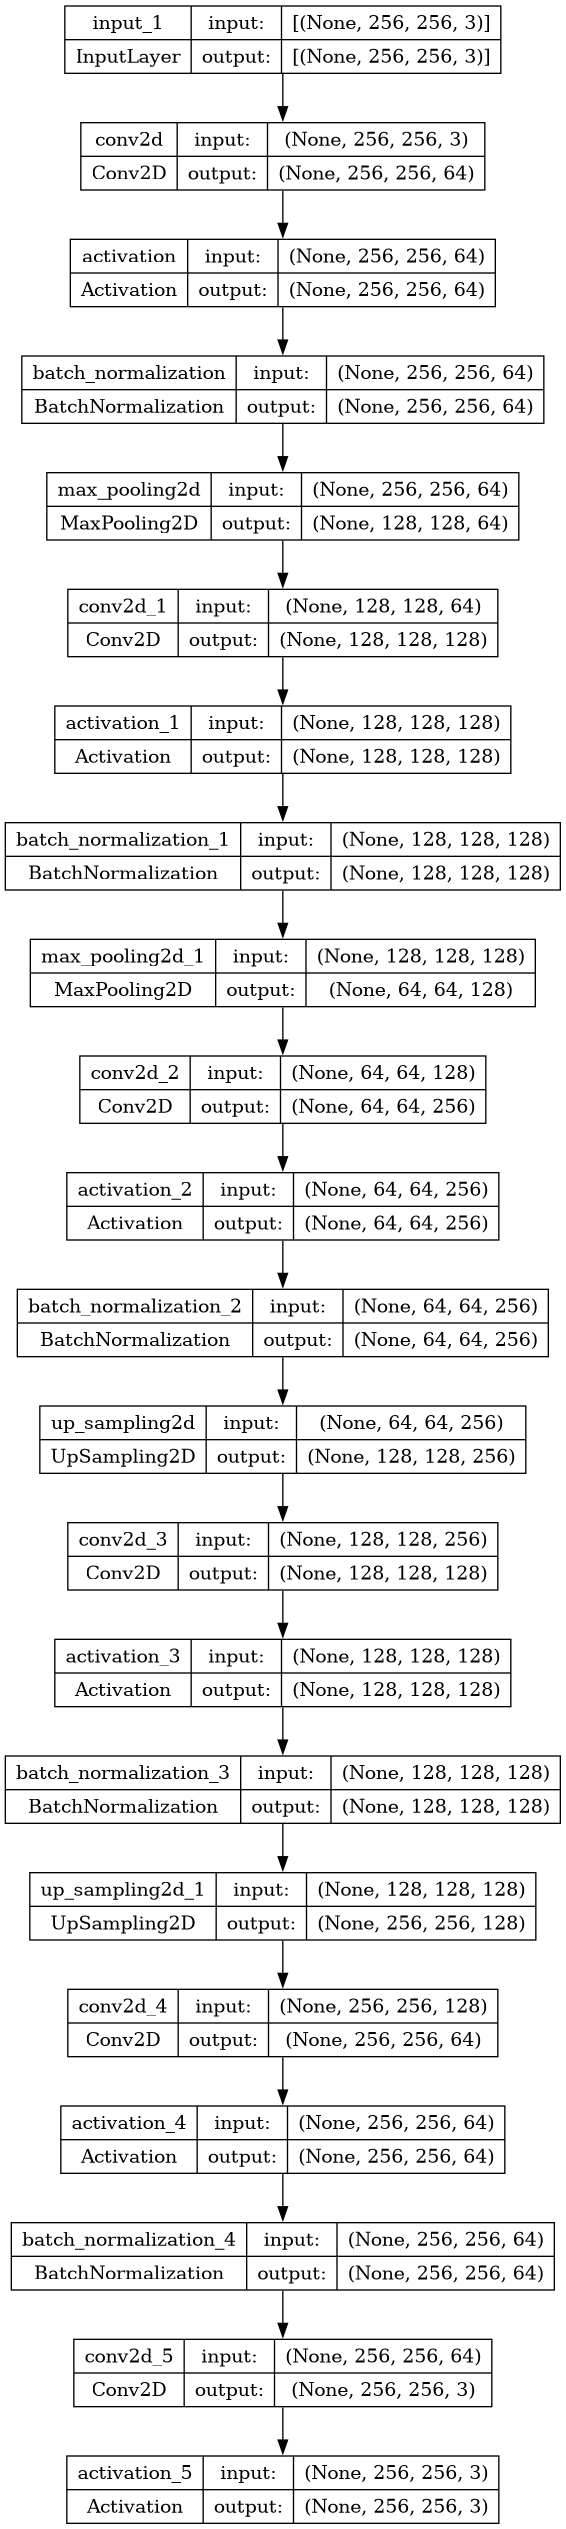

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [14]:
# Define callbacks
checkpoint = ModelCheckpoint(
    "best_model.h5", 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,  
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

In [16]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.0001,
    verbose=1
)

In [17]:
# Verify data loading for a batch
x_sample, y_sample = next(iter(train_generator))
print(f'Sample batch shapes: {x_sample.shape}, {y_sample.shape}')  

Sample batch shapes: (32, 256, 256, 3), (32, 256, 256, 3)


In [25]:
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.6579
Epoch 1: val_loss did not improve from 0.04838
13/13 [==============================] - 10s 748ms/step - loss: 0.0234 - accuracy: 0.6579 - val_loss: 0.0504 - val_accuracy: 0.5506 - lr: 2.0000e-04
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.6437
Epoch 2: val_loss did not improve from 0.04838
13/13 [==============================] - 9s 683ms/step - loss: 0.0231 - accuracy: 0.6437 - val_loss: 0.0524 - val_accuracy: 0.5703 - lr: 2.0000e-04
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0230 - accuracy: 0.6775
Epoch 3: val_loss did not improve from 0.04838
13/13 [==============================] - 9s 691ms/step - loss: 0.0230 - accuracy: 0.6776 - val_loss: 0.0495 - val_accuracy: 0.5516 - lr: 2.0000e-04
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.6400
Epoch 4: val_loss did not improve 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.6862
Epoch 6: val_loss did not improve from 0.04708
13/13 [==============================] - 9s 698ms/step - loss: 0.0223 - accuracy: 0.6862 - val_loss: 0.0489 - val_accuracy: 0.5572 - lr: 2.0000e-04
Epoch 7/100
13/13 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.6810
Epoch 7: val_loss did not improve from 0.04708
13/13 [==============================] - 10s 725ms/step - loss: 0.0226 - accuracy: 0.6810 - val_loss: 0.0482 - val_accuracy: 0.5571 - lr: 2.0000e-04
Epoch 8/100
13/13 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.6657
Epoch 8: val_loss improved from 0.04708 to 0.04560, saving model to best_model.h5
13/13 [==============================] - 9s 689ms/step - loss: 0.0225 - accuracy: 0.6657 - val_loss: 0.0456 - val_accuracy: 0.1538 - lr: 2.0000e-04
Epoch 9/100
13/13 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.6423
Epoch 9: va

In [26]:
# Visualization and prediction testing
test_images, ground_truth = next(iter(test_generator))  
predicted_images = model.predict(test_images)

1/1 [==============================] - 0s 22ms/step


In [27]:
# Visualization function modified to show three images (original, ground truth, and predicted)
def plot_images(original, ground_truth, predicted):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Original Image', color = 'green', fontsize = 10)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth)
    plt.title('Ground Truth ', color = 'black', fontsize = 10)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted)
    plt.title('Enhanced ', color = 'Red', fontsize = 10)
    plt.axis('off')
    plt.show()

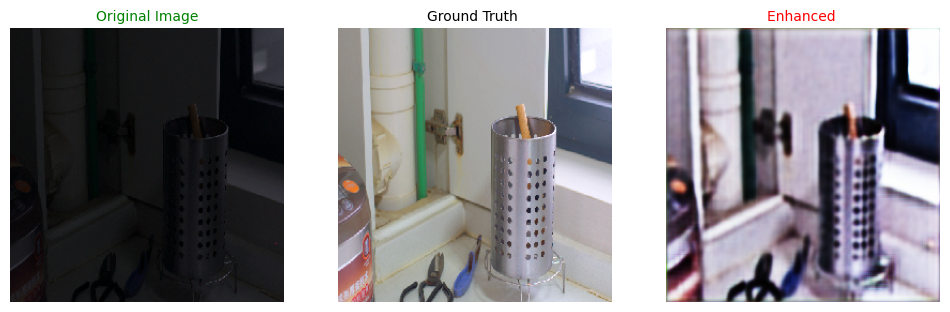

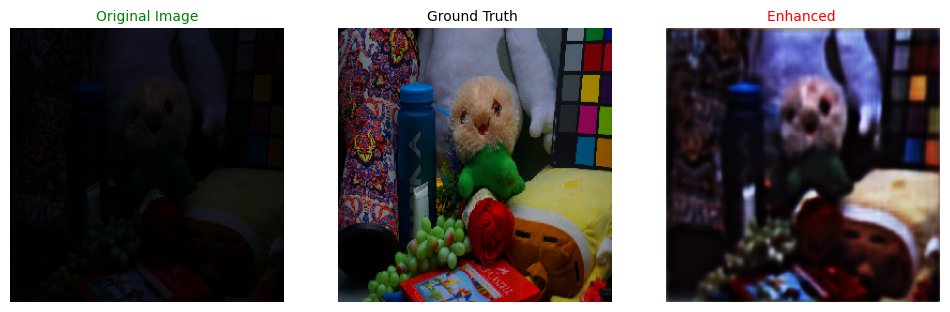

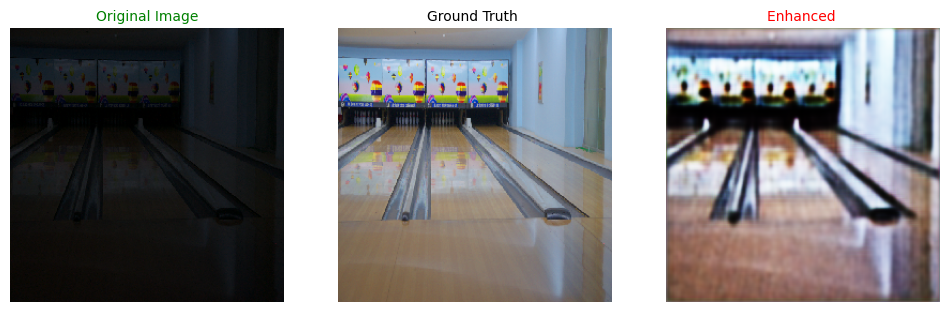

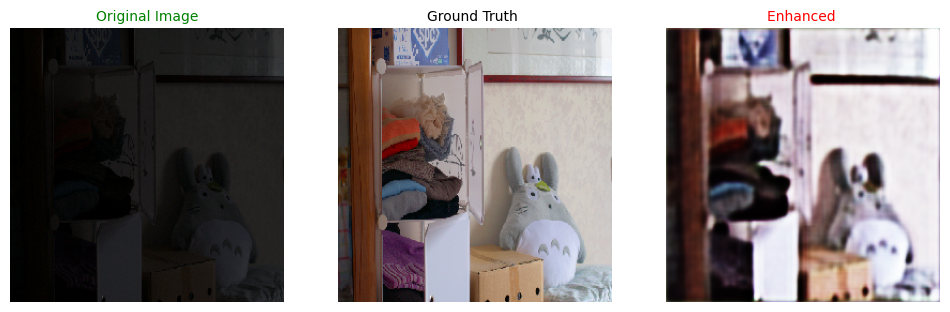

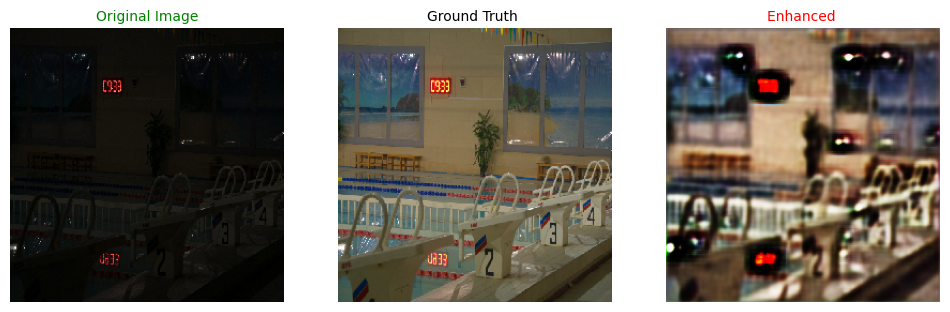

In [28]:
for original, truth, pred in zip(test_images, ground_truth, predicted_images):
    plot_images(original, truth, pred)

In [30]:
# Fetch one batch of test data
test_images, ground_truth = next(iter(test_generator))
print(f"Test image shape: {test_images[0].shape}")

# Check if normalization is applied correctly
sample_image = test_images[0].astype("float32") / 255.0
print(f"Max pixel value: {sample_image.max()}, Min pixel value: {sample_image.min()}")

Test image shape: (256, 256, 3)
Max pixel value: 0.0023529413156211376, Min pixel value: 0.0


In [31]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_model(model, generator, num_samples=10):
    """Evaluate the model using PSNR on a number of samples."""
    psnr_values = []

    for _ in range(num_samples):
        test_images, ground_truth = next(iter(generator))
        predicted_images = model.predict(test_images)
        for gt, pred in zip(ground_truth, predicted_images):
            # Normalize the images
            gt = gt.astype("float32") / 255.0
            pred = pred.astype("float32") / 255.0

            # Calculate PSNR for each pair and accumulate
            current_psnr = psnr(gt, pred, data_range=gt.max() - gt.min())
            psnr_values.append(current_psnr)

    average_psnr = np.mean(psnr_values)
    return average_psnr

# Evaluation function after model training
average_psnr = evaluate_model(model, test_generator, num_samples=30)

print(f"Average PSNR: {average_psnr:.2f}")

1/1 [==============================] - 0s 21ms/step
Average PSNR: 15.70
